In [101]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import cross_val_score, StratifiedKFold #кросс-валидация
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna
%matplotlib inline


In [102]:
data = pd.read_csv('data/train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [103]:
X = data.drop('Activity', axis=1)
y = data['Activity']

In [104]:
class_counts = y.value_counts()
print(class_counts)
print(class_counts / len(y))

Activity
1    2034
0    1717
Name: count, dtype: int64
Activity
1    0.542255
0    0.457745
Name: count, dtype: float64


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.3)

## Логистическая регрессия

In [106]:
#baseline
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)

#Обучаем модель
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


### Оптимизация GridSearchCV

In [107]:
param_grid = {
    'penalty': ['l2', None],
    'solver': ['saga', 'lbfgs'],
    'C': [0.01, 0.1, 1, 10] 
}

grid_search = GridSearchCV(
        estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=1000 #количество итераций
    ), 
    param_grid=param_grid,
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train)
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

CPU times: total: 6.81 s
Wall time: 2min 36s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Наилучшее значение точности при кросс-валидаци: 0.77


### Оптимизация RandomizedSearchCV

In [108]:
param_distributions = {'penalty': ['l2', None] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 8.53 s
Wall time: 55 s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': np.float64(0.12)}


### Оптимизация Hyperopt

In [109]:
# зададим пространство поиска гиперпараметров
space = {
    'penalty': hp.choice('penalty', ['l2', None]),
    'solver': hp.choice('solver', ['lbfgs', 'sag', 'saga']),
    'C': hp.uniform('C', 0.01, 10)
}

# зафксируем random_state
random_state = 42


def hyperopt_logreg(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    model = linear_model.LogisticRegression(
        penalty=params['penalty'],
        solver=params['solver'],
        C=params['C'],
        random_state=random_state,
        max_iter=1000 
    )
  
    # кросс-валидация
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [110]:
%%time
# Подбор гиперпараметров

trials = Trials() #логирование результатов

best=fmin(hyperopt_logreg, # функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [06:38<00:00, 19.91s/trial, best loss: -0.7781579421534522]
Наилучшие значения гиперпараметров {'C': np.float64(0.42219097013541806), 'penalty': np.int64(0), 'solver': np.int64(0)}
CPU times: total: 2.72 s
Wall time: 6min 38s


In [111]:
penalty_list = ['l2', None]
solver_list = ['lbfgs', 'sag']

# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    penalty=penalty_list[best['penalty']],
    solver=solver_list[best['solver']],
    C=best['C'],
    random_state=random_state,
    max_iter=1000
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.88
f1_score на тестовом наборе: 0.78


In [112]:
# увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_logreg, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации
          max_evals=40, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 40/40 [01:15<00:00,  3.79s/trial, best loss: -0.7912768400609893]
Наилучшие значения гиперпараметров {'C': np.float64(0.03807139697470416), 'penalty': np.int64(0), 'solver': np.int64(0)}


In [113]:
# Заново посчитаем
penalty_list = ['l2', None]
solver_list = ['lbfgs', 'sag']

# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    penalty=penalty_list[best['penalty']],
    solver=solver_list[best['solver']],
    C=best['C'],
    random_state=random_state,
    max_iter=1000
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.84
f1_score на тестовом наборе: 0.79


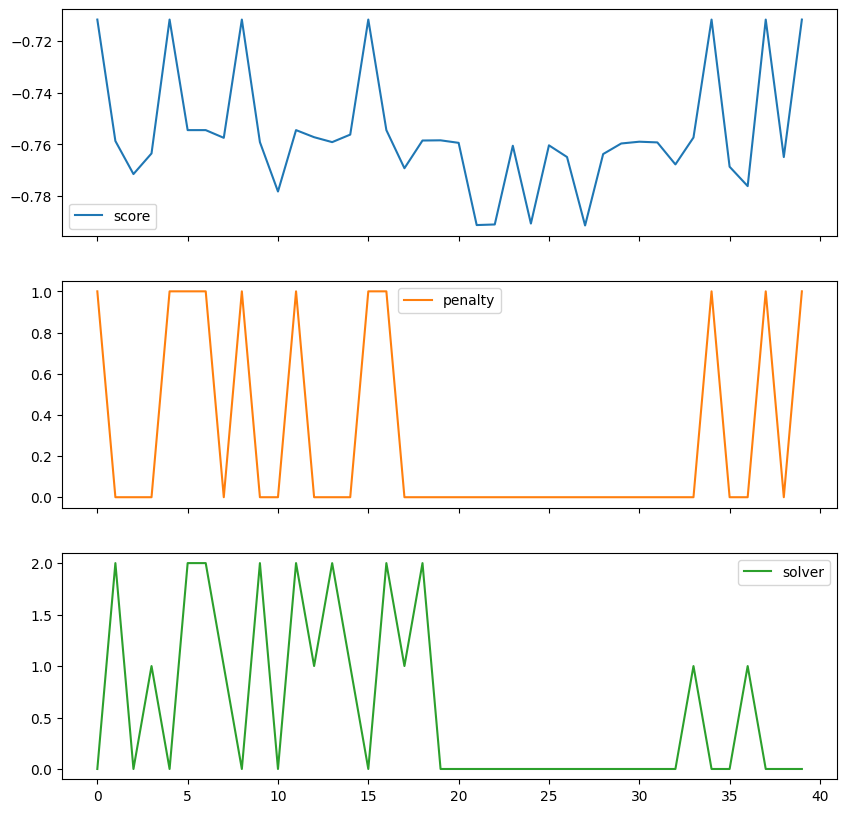

In [114]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['penalty'][0],
                      x['misc']['vals']['solver'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'penalty', 'solver'])
tpe_results_df.plot(subplots=True,figsize=(10, 10));

### Оптимизация Optuna

In [115]:
def optuna_logreg(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty',['l2', None])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
  C = trial.suggest_float('C', 0.01, 10.0)
  
  model = linear_model.LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C,
        random_state=random_state,
        max_iter=1000
    )
  
  # Кросс-валидация
  score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
  return score
  

In [116]:
%%time
# cоздаем объект исследования

study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_logreg, n_trials=20)

[I 2025-08-17 18:50:57,260] A new study created in memory with name: LogisticRegression
[I 2025-08-17 18:51:21,022] Trial 0 finished with value: 0.7578645253928619 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 6.6822739389135934}. Best is trial 0 with value: 0.7578645253928619.
[I 2025-08-17 18:51:44,284] Trial 1 finished with value: 0.7475981251825792 and parameters: {'penalty': None, 'solver': 'sag', 'C': 1.3543192851571388}. Best is trial 0 with value: 0.7578645253928619.
[I 2025-08-17 18:51:46,874] Trial 2 finished with value: 0.7567799552212426 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 4.969712226009803}. Best is trial 0 with value: 0.7578645253928619.
[I 2025-08-17 18:52:11,660] Trial 3 finished with value: 0.7574086389438388 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 5.081227103001295}. Best is trial 0 with value: 0.7578645253928619.
[I 2025-08-17 18:52:17,361] Trial 4 finished with value: 0.7117341925662648 and parameters: {'penalty': None

CPU times: total: 1.86 s
Wall time: 3min 19s


In [117]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.042711253969491825}
f1_score на обучающем наборе: 0.79


In [118]:
best_params = study.best_params
# Обучаем модель с лучшими параметрами
model = linear_model.LogisticRegression(
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    C=best_params['C'],
    random_state=random_state,
    max_iter=1000
)
model.fit(X_train, y_train)

LogisticRegression(C=0.042711253969491825, max_iter=1000, random_state=42)

In [119]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.84
f1_score на тестовом наборе: 0.79


### *Вывод:*

| Метод              | Время обучения | F1 на тесте | Комментарий                                                 |
| ------------------ | -------------- | ----------- | ----------------------------------------------------------- |
| Baseline           | —              | 0.78        | Базовая модель без подбора гиперпараметров                  |
| GridSearchCV       | 2 мин 36 сек   | 0.79        | Подбор параметров показал небольшой прирост                 |
| RandomizedSearchCV | 55 сек    | 0.79        | Быстрее GridSearch, результат тот же                        |
| Hyperopt           | 6 мин 36 сек   | 0.79        | Более сложная оптимизация, но F1 не улучшилась              |
| Optuna             | 3 мин 19 сек    | 0.79        | Результат аналогичен другим методам |


Логистическая регрессия показывает стабильный F1 0.79 после подбора гиперпараметров. Продвинутые методы (Hyperopt, Optuna) потребовали намного больше времени подбора и не дали заметного прироста по сравнению с базовыми (Grid/RandomizedSearch), но они могут быть полезны при большем числе параметров или более сложных пространствах поиска. 

## Случайный лес

In [120]:
# baseline
# Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.79


### Оптимизация GridSearchCV

In [121]:
param_grid = {'n_estimators': [100, 150, 200, 250, 300],
              'min_samples_leaf': [3, 5, 7],
              'max_depth': [10, 15, 25]
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 3.67 s
Wall time: 56.1 s
f1_score на обучающем наборе: 0.98
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 25, 'min_samples_leaf': 3, 'n_estimators': 300}


### Оптимизация RandomizedSearchCV

In [122]:
param_distributions = {
            'n_estimators': list(range(100, 300, 30)),
            'min_samples_leaf': [3, 5, 7],
            'max_depth': [10, 15, 20, 25]
}
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 3.31 s
Wall time: 57.5 s
f1_score на обучающем наборе: 0.97
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 250, 'min_samples_leaf': 3, 'max_depth': 20}


### Оптимизация Hyperopt

In [123]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
       'max_depth' : hp.quniform('max_depth', 5, 25, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }

In [124]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [125]:
%%time
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации
          max_evals=40, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 40/40 [01:16<00:00,  1.92s/trial, best loss: -0.8212903207103845]
Наилучшие значения гиперпараметров {'max_depth': np.float64(16.0), 'min_samples_leaf': np.float64(3.0), 'n_estimators': np.float64(190.0)}
CPU times: total: 1.95 s
Wall time: 1min 16s


In [126]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.97
f1_score на тестовом наборе: 0.80


### Оптимизация Optuna

In [127]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', low=100, high=300, step=10)
  max_depth = trial.suggest_int('max_depth', low=5, high=25, step=1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', low=3, high=7, step=1)


  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [128]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

[I 2025-08-17 18:57:31,840] A new study created in memory with name: RandomForestClassifier
[I 2025-08-17 18:57:32,743] Trial 0 finished with value: 0.8646196789951152 and parameters: {'n_estimators': 150, 'max_depth': 7, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8646196789951152.
[I 2025-08-17 18:57:34,004] Trial 1 finished with value: 0.9338900487125957 and parameters: {'n_estimators': 140, 'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.9338900487125957.
[I 2025-08-17 18:57:34,839] Trial 2 finished with value: 0.895231465367212 and parameters: {'n_estimators': 120, 'max_depth': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9338900487125957.
[I 2025-08-17 18:57:35,902] Trial 3 finished with value: 0.9134851138353766 and parameters: {'n_estimators': 140, 'max_depth': 9, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9338900487125957.
[I 2025-08-17 18:57:37,745] Trial 4 finished with value: 0.9426884334838486 and parameters: {'n_esti

CPU times: total: 1min 48s
Wall time: 1min 51s


In [129]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения гиперпараметров {'n_estimators': 280, 'max_depth': 25, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.98
f1_score на тестовом наборе: 0.80


### *Вывод:*

| Метод              | Время обучения | F1 на трейн | F1 на тесте | Комментарий                                                       |
| ------------------ | -------------- | ----------- | ----------- | ----------------------------------------------------------------- |
| Baseline           | —              | 1.00           | 0.79        | Базовая модель без подбора гиперпараметров                        |
| GridSearchCV       | 56 сек         | 0.98        | 0.80        | Подбор улучшил тестовый результат, сильное переобучение на трейне |
| RandomizedSearchCV | 57 сек         | 0.97        | 0.80        | Медленнее GridSearch, результат на тесте аналогичен, на трейне переобучение                 |
| Hyperopt           | 1 мин 16 сек   | 0.97        | 0.80        | Переобучение на трейне, но F1 теста не улучшился                              |
| Optuna             | 1 мин 48 сек   | 0.98        | 0.80        | Быстро и стабильно, аналогично RandomizedSearch, так же переобучение                   |

Случайный лес демонстрирует высокую точность на трейне (0.97–0.98) и стабильный F1 на тесте (0.80). GridSearch в данном случае оказался быстрее, чем RandomizedSearch, хотя обычно ожидается обратное. Продвинутые методы (Hyperopt, Optuna) позволяют подобрать гиперпараметры эффективно, но тестовый результат не улучшился.


### Общий вывод:

1. Логистическая регрессия: подбор гиперпараметров практически не улучшает результат (F1 теста 0.78 → 0.79).

2. Случайный лес: значительно улучшает результат на трейне и немного на тесте (F1 теста 0.79 → 0.80), но сильно переобучается на тренировочных данных.

3. RandomizedSearchCV обычно быстрее GridSearch, но в случае случайного леса оказалось наоборот.

4. Hyperopt и Optuna позволяют гибко подбирать гиперпараметры, но время обучения может быть больше.


